In [11]:
import sys
sys.version

'3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]'

In [12]:
!pip install ydata-profiling

In [13]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import ydata_profiling
import statsmodels.api as sm
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
from scipy import stats
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from matplotlib.dates import DateFormatter
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
plt.rc('font', family='Malgun Gothic')

In [14]:
pip list

Package                   Version
------------------------- ----------
altgraph                  0.17.4
annotated-types           0.7.0
appdirs                   1.4.4
asttokens                 2.4.1
attrs                     23.2.0
beautifulsoup4            4.12.3
bs4                       0.0.2
certifi                   2024.2.2
charset-normalizer        3.3.2
cmdstanpy                 1.2.2
colorama                  0.4.6
comm                      0.2.2
contourpy                 1.2.0
cycler                    0.12.1
Cython                    3.0.10
dacite                    1.8.1
debugpy                   1.8.1
decorator                 5.1.1
et-xmlfile                1.1.0
exceptiongroup            1.2.1
executing                 2.0.1
filelock                  3.13.4
fonttools                 4.48.1
frozendict                2.4.0
fsspec                    2024.3.1
holidays                  0.46
html5lib                  1.1
htmlmin                   0.1.12
huggingface-hub       

In [15]:
# 첫 데이터를 로드
df2 = pd.read_excel('./쇼핑몰실습.xlsx')
# 데이터 전처리
df3 = df2[df2.업체명 != '셀러테스트']
df4 = df2[df2.판매금액 != 0]
df5 = df4.drop(['제작문구 내역', '초도상품', '제조사'], axis=1)#매출 데이터로 활용 예정

In [17]:
# RFM 데이터 프레임 생성
df_rfm = df5.groupby('업체명').agg({
    '주문일자': lambda x: (pd.Timestamp.today() - x.max()).days,  # Recency: 최근 구매일로부터 경과한 일수
    '주문번호': 'count',  # Frequency: 구매 횟수
    '판매금액': 'sum'  # Monetary: 총 구매 금액
})
df_rfm.columns = ['Recency', 'Frequency', 'Monetary']
# RFM 스코어 계산
quantiles = df_rfm.quantile(q=[0.33, 0.66])
# R, F, M 점수 계산 함수
def r_score(x):
    if x <= quantiles['Recency'][0.33]:
        return 3
    elif x <= quantiles['Recency'][0.66]:
        return 2
    else:
        return 1
def fm_score(x, c):
    if x <= quantiles[c][0.33]:
        return 1
    elif x <= quantiles[c][0.66]:
        return 2
    else:
        return 3
# R, F, M 점수 부여
df_rfm['R'] = df_rfm['Recency'].apply(r_score)
df_rfm['F'] = df_rfm['Frequency'].apply(fm_score, args=('Frequency',))
df_rfm['M'] = df_rfm['Monetary'].apply(fm_score, args=('Monetary',))
# RFM 스코어 합산
df_rfm['RFM_Score'] = df_rfm['R'] + df_rfm['F'] + df_rfm['M']
# 그룹 나누기
def rfm_group(score):
    if score >= 9:
        return '높은 그룹'
    elif score >= 6:
        return '보통 그룹'
    else:
        return '낮은 그룹'

df_rfm['RFM_Group'] = df_rfm['RFM_Score'].apply(rfm_group)

# R, F, M 값을 카테고리화 (1, 2, 3으로)
df_rfm['R_cat'] = pd.cut(df_rfm['Recency'], bins=[0, quantiles['Recency'][0.33], quantiles['Recency'][0.66], df_rfm['Recency'].max()], labels=[3, 2, 1], include_lowest=True)
df_rfm['F_cat'] = pd.cut(df_rfm['Frequency'], bins=[0, quantiles['Frequency'][0.33], quantiles['Frequency'][0.66], df_rfm['Frequency'].max()], labels=[1, 2, 3], include_lowest=True)
df_rfm['M_cat'] = pd.cut(df_rfm['Monetary'], bins=[0, quantiles['Monetary'][0.33], quantiles['Monetary'][0.66], df_rfm['Monetary'].max()], labels=[1, 2, 3], include_lowest=True)

df_rfm_sorted = df_rfm.sort_values(by='RFM_Score', ascending=False)
df_rfm_sorted.to_excel('rfm_sorted.xlsx', index=True)
print("RFM 값을 높은 순으로 정렬한 데이터가 'rrfm_sorted.xlsx' 파일로 저장되었습니다.")

# 카이제곱 검정 함수
def chi2_test(var1, var2):
    contingency_table = pd.crosstab(var1, var2)
    chi2, p, _, _ = chi2_contingency(contingency_table)  # 자유도 변수(_)는 사용하지 않음
    return chi2, p
# R vs F
chi2_R_F, p_R_F = chi2_test(df_rfm['R_cat'], df_rfm['F_cat'])
print(f"R-F - Chi2: {chi2_R_F}, p-value: {p_R_F}")
# R vs M
chi2_R_M, p_R_M = chi2_test(df_rfm['R_cat'], df_rfm['M_cat'])
print(f"R-M - Chi2: {chi2_R_M}, p-value: {p_R_M}")
# F vs M
chi2_F_M, p_F_M = chi2_test(df_rfm['F_cat'], df_rfm['M_cat'])
print(f"F-M - Chi2: {chi2_F_M}, p-value: {p_F_M}")

df_rfm_sorted = df_rfm.drop(columns=['Recency', 'Frequency', 'Monetary', 'R_cat', 'F_cat', 'M_cat'])


RFM 값을 높은 순으로 정렬한 데이터가 'rrfm_sorted.xlsx' 파일로 저장되었습니다.
R-F - Chi2: 15.998717135685029, p-value: 0.003020885546422502
R-M - Chi2: 3.686756506804069, p-value: 0.4500550446254862
F-M - Chi2: 55.992158805654654, p-value: 2.0127807988336415e-11


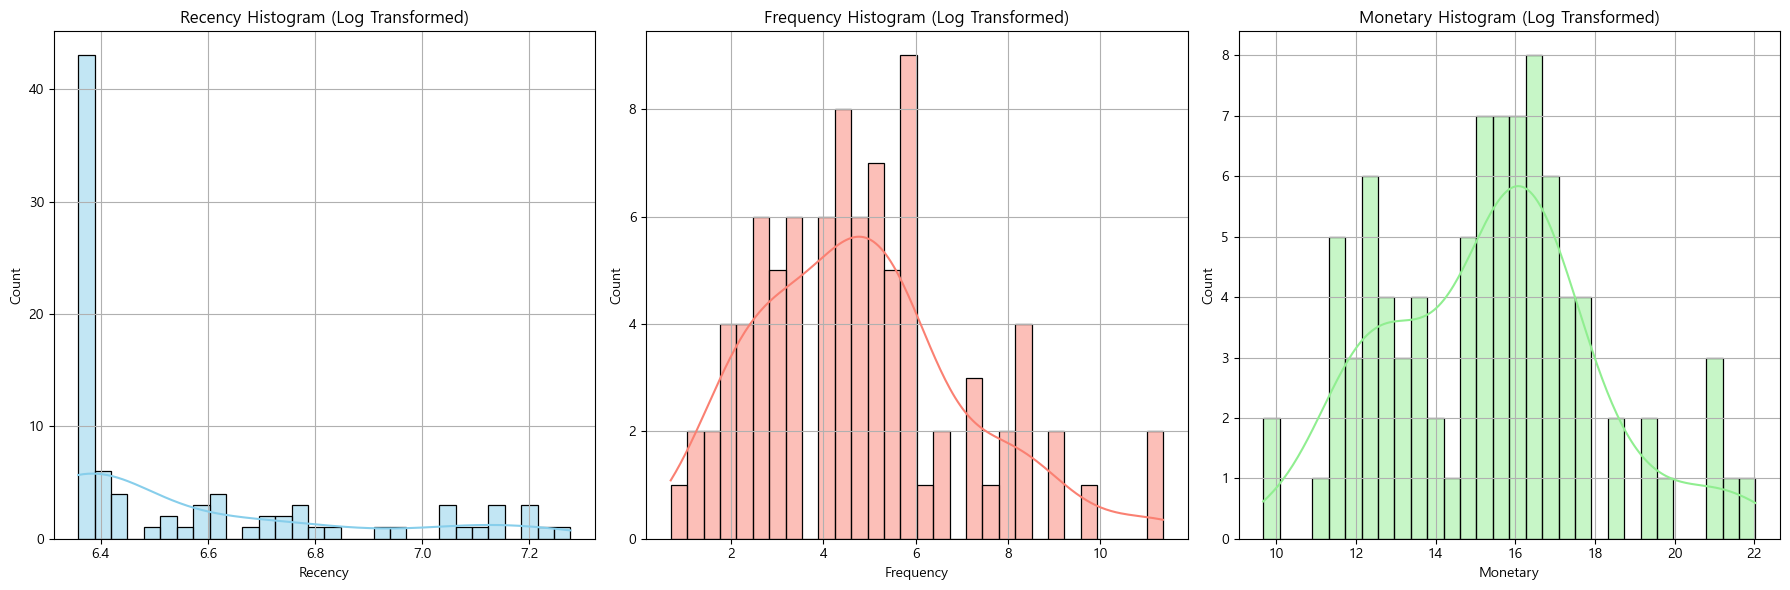

In [19]:
import numpy as np

df_rfm['Recency'] = np.log1p(df_rfm['Recency'])  # log1p는 log(1 + x)로 0 값을 처리할 수 있음
df_rfm['Frequency'] = np.log1p(df_rfm['Frequency'])
df_rfm['Monetary'] = np.log1p(df_rfm['Monetary'])



# 서브플롯 생성
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# Recency 히스토그램
sns.histplot(df_rfm['Recency'], kde=True, ax=axs[0], color='skyblue', bins=30)
axs[0].set_title('Recency Histogram (Log Transformed)')
axs[0].set_xlabel('Recency')
axs[0].set_ylabel('Count')
axs[0].grid(True)
# Frequency 히스토그램
sns.histplot(df_rfm['Frequency'], kde=True, ax=axs[1], color='salmon', bins=30)
axs[1].set_title('Frequency Histogram (Log Transformed)')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Count')
axs[1].grid(True)
# Monetary 히스토그램
sns.histplot(df_rfm['Monetary'], kde=True, ax=axs[2], color='lightgreen', bins=30)
axs[2].set_title('Monetary Histogram (Log Transformed)')
axs[2].set_xlabel('Monetary')
axs[2].set_ylabel('Count')
axs[2].grid(True)
# 레이아웃 조정
plt.tight_layout()
plt.show()


In [20]:
df5['결제방법'] = df5['결제방법'].replace({    
    "신 + 적": "신용카드" , "신 + 포": "신용카드",
    "신 + 웰컴": "신용카드", "신 + 적 + 포": "신용카드", "-":"기타",
    "현 + 적": "현금", "현 + 포": "현금", "무통장입금":"현금", 
    "현 + 적 + 포": "현금", "가상계좌":"현금", "현금간편결제":"현금",
    "적 + 포": "마일리지","포인트":"마일리지","적립금":"마일리지",
    "웰컴마일":"마일리지"," + 포":"마일리지",
    "정 + 적": "할부", "정 + 적 + 포": "할부", "후불": "할부",
    "정 + 포": "할부", "후 + 적": "할부", "정기결제":"할부",
    "후 + 적 + 포": "할부", "후 + 포": "할부",
    'nan': "기타"})

df5['처리상태'] = df5['처리상태'].replace({
    '교환완료':'결제완료', '구매확정':'결제완료', '배송완료':'결제완료', '배송준비':'결제완료', '배송중':'결제완료',
    '부분취소':'결제완료', '환불완료':'결제완료', '주문취소':'미결제', '부분환불':'결제완료', '상담취소':'미결제',
    '상담형상품접':'미결제', '시안확인요청':'미결제', '':'미결제', '환불승':'결제완료', '환불완':'결제완료',
    '환불요청':'결제완료', '후불반려':'미결제'})

#매출 데이터

C:\Users\wltjr\AppData\Local\Temp\ipykernel_31904\1863144975.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['연도월'] = pd.to_datetime(df_filtered['주문일자'], format='%Y/%m').dt.to_period('M')


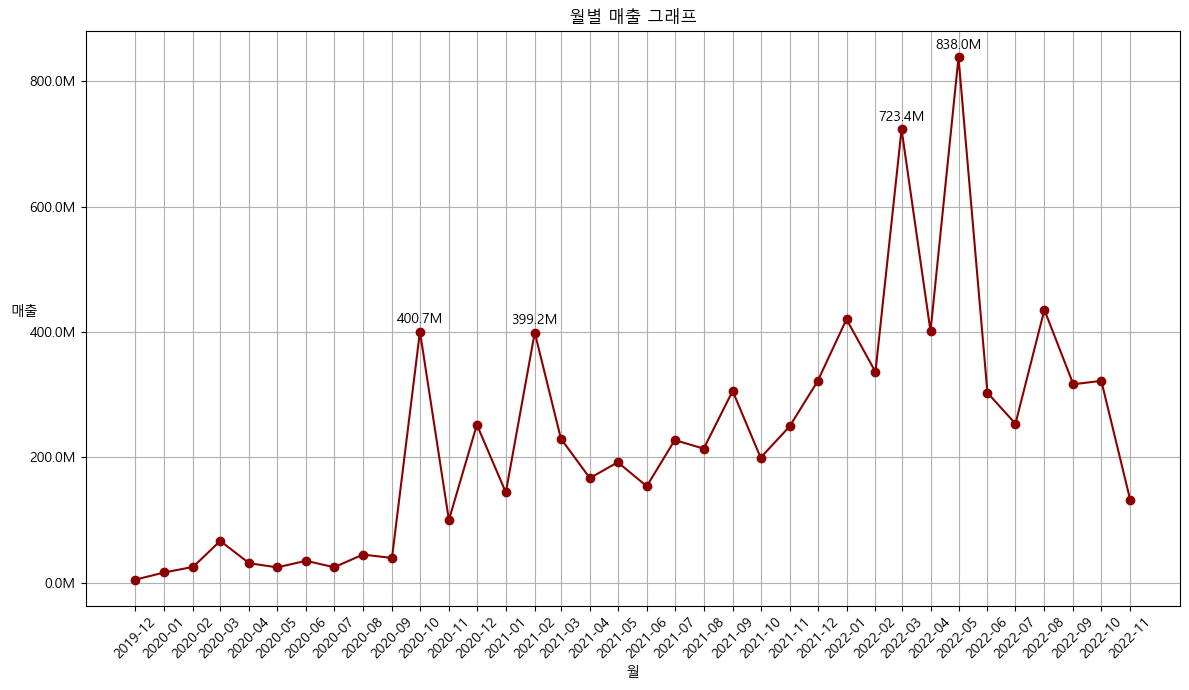

In [21]:
df_filtered = df5[df5['처리상태'] == '결제완료']
# '연도월' 컬럼을 datetime 형식으로 변환
df_filtered['연도월'] = pd.to_datetime(df_filtered['주문일자'], format='%Y/%m').dt.to_period('M')
# 월/년별 판매금액 집계
monthly_sales = df_filtered.groupby('연도월')['판매금액'].sum().reset_index()
# '연도월' 컬럼을 datetime 형식으로 변환하여 시계열 데이터로 사용
monthly_sales['연도월'] = monthly_sales['연도월'].dt.to_timestamp('D')
#백만 단위를 'M'으로 표시
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
# 그래프 시각화
plt.figure(figsize=(12, 7))
plt.plot(monthly_sales['연도월'], monthly_sales['판매금액'], marker='o',color='darkred')
plt.title('월별 매출 그래프')
plt.xlabel('월')
plt.ylabel('매출', rotation=0)
# 데이터에 등록된 월을 x축으로 표시
plt.xticks(['2019-12','2020-01','2020-02','2020-03','2020-04','2020-05','2020-06','2020-07','2020-08','2020-09','2020-10','2020-11','2020-12',
 '2021-01','2021-02','2021-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12',
'2022-01','2022-02','2022-03','2022-04','2022-05','2022-06','2022-07','2022-08','2022-09','2022-10','2022-11'],rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
date_formatter = DateFormatter('%Y-%m')
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.grid(True)
highlight_months = ['2020-10', '2021-02', '2022-03', '2022-05']
for i, row in monthly_sales.iterrows():
     if row['연도월'].strftime('%Y-%m') in highlight_months:
          plt.annotate(f"{row['판매금액'] / 1e6:.1f}M",
                         (row['연도월'], row['판매금액']),
                         textcoords="offset points",  # how to position the text
                         xytext=(0, 6),  # distance from text to points (x,y)
                         ha='center')
plt.tight_layout()
plt.savefig('monthly_graph_image')
plt.show()

#월별 매출 그래프

C:\Users\wltjr\AppData\Local\Temp\ipykernel_31904\1171696250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['주문일자'] = pd.to_datetime(df_filtered['주문일자'], errors='coerce')
C:\Users\wltjr\AppData\Local\Temp\ipykernel_31904\1171696250.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['연도'] = df_filtered['주문일자'].dt.year


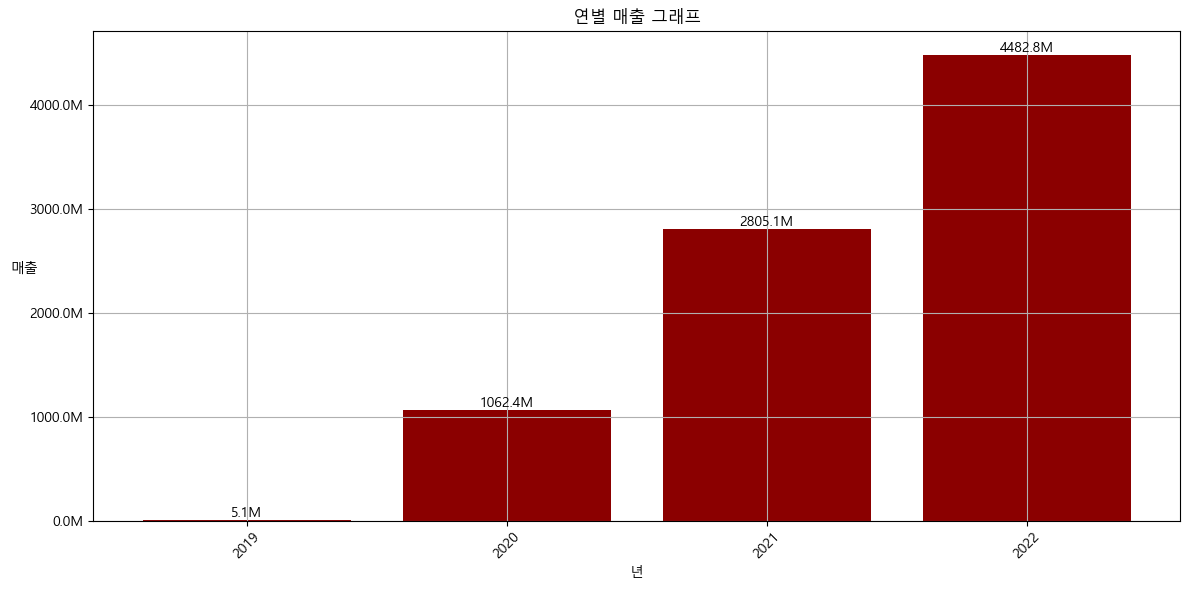

In [22]:
# 데이터 필터링: '결제완료' 상태의 주문만 선택
df_filtered = df5[df5['처리상태'] == '결제완료']

# '주문일자'를 datetime 형식으로 변환 (필요한 경우)
df_filtered['주문일자'] = pd.to_datetime(df_filtered['주문일자'], errors='coerce')

# '연도' 컬럼 생성: '주문일자'에서 연도를 추출
df_filtered['연도'] = df_filtered['주문일자'].dt.year

# 연도별 판매금액 집계
yearly_sales = df_filtered.groupby('연도')['판매금액'].sum().reset_index()

# y축 포맷터 함수 정의: 금액을 백만 단위로 표시
def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

# 그래프 시각화
plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_sales['연도'], yearly_sales['판매금액'], color='darkred')
plt.title('연별 매출 그래프')
plt.xlabel('년')
plt.ylabel('매출', rotation=0)

# x축 레이블 설정
plt.xticks(yearly_sales['연도'], rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)

# x축 포맷을 '연도' 형식으로 설정
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x)}'))

# 각 바에 금액 레이블 추가
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval * 1e-6:.1f}M', va='bottom', ha='center')

plt.grid(True)
plt.tight_layout()
plt.savefig('yearly_graph_image.png')
plt.show()


In [23]:
# 할부 기간에 따른 데이터 생성 함수 정의
df6 = df4.drop(['제작문구 내역', '초도상품', '제조사'], axis=1)#순이익 데이터로 활용 예정

def create_installment_rows(row):
    rows = []
    if row['할부기간'] == '6개월':
        months = 6
    elif row['할부기간'] == '12개월':
        months = 12
    elif row['할부기간'] == '18개월':
        months = 18
    elif row['할부기간'] == '24개월':
        months = 24
    else:
        return [row]
    
    installment_amount = row['판매금액'] / months
    order_date = pd.to_datetime(row['주문일자'])
    
    for i in range(months):
        new_row = row.copy()
        new_row['주문일자'] = order_date + pd.DateOffset(months=i)
        new_row['판매금액'] = installment_amount
        new_row['할부개월'] = f"{i+1}/{months}"
        rows.append(new_row)
    
    return rows

# 할부 데이터를 처리하여 각 달로 나누기
installment_rows = []
for idx, row in df6.iterrows():
    installment_rows.extend(create_installment_rows(row))

# 새로운 데이터프레임 생성
installment_df = pd.DataFrame(installment_rows)

# 월별 매출 계산
installment_df['연도월'] = installment_df['주문일자'].dt.to_period('M')
installment_df['연도월'] = installment_df['연도월'].astype(str)
monthly_sales = installment_df.groupby('연도월')['판매금액'].sum().reset_index()

# 연도별 매출 계산
installment_df['연도'] = installment_df['주문일자'].dt.year
yearly_sales = installment_df.groupby('연도')['판매금액'].sum().reset_index()

# y축 값 포맷터 함수 정의 (백만 단위)
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

# 엑셀 파일 생성
wb = Workbook()

# 기본 시트 제거
default_sheet = wb.active
wb.remove(default_sheet)

# 할부 처리 데이터 시트
ws1 = wb.create_sheet(title='할부처리데이터')
for r in dataframe_to_rows(installment_df, index=False, header=True):
    ws1.append(r)

#할부 데이터

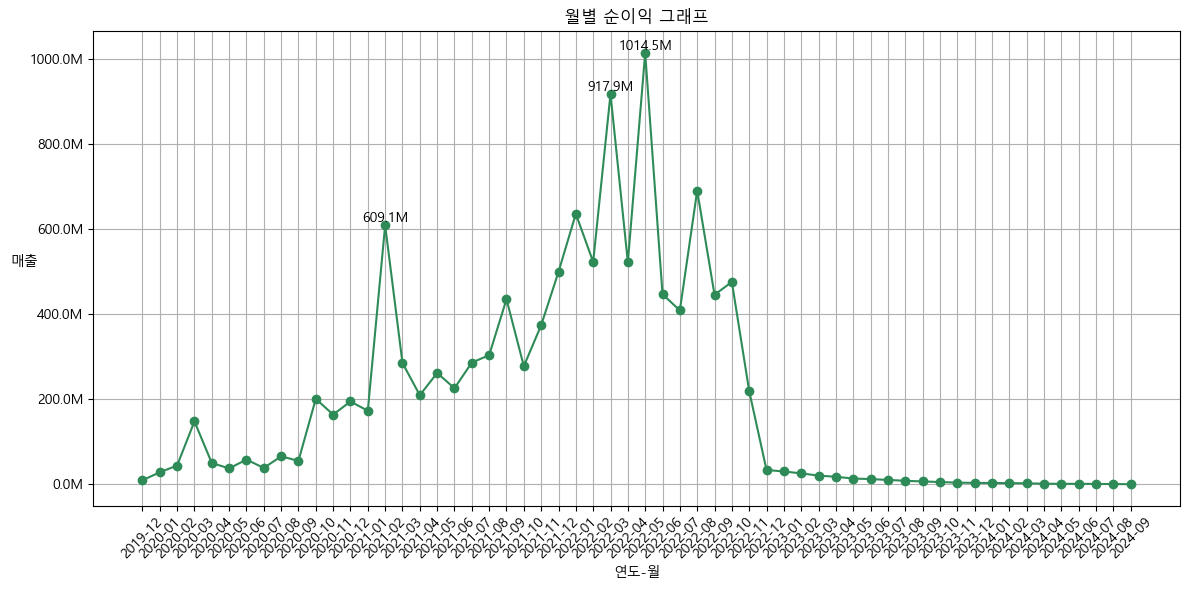

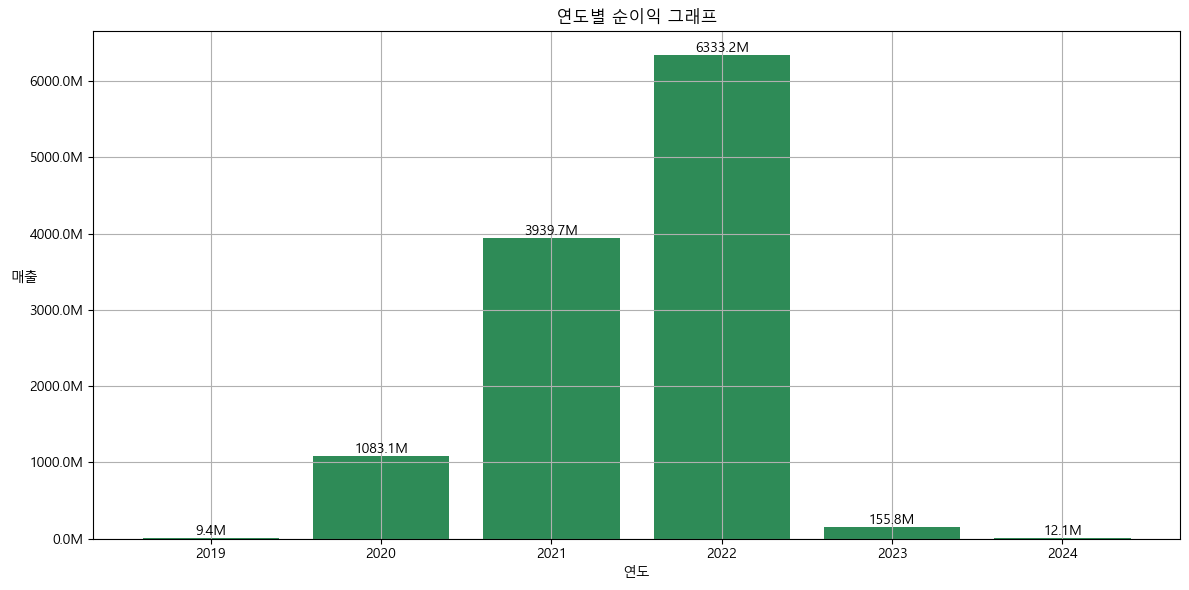

In [24]:
# 순이익 처리
df6['결제방법'] = df6['결제방법'].replace({    
    "신 + 적": "신용카드" , "신 + 포": "신용카드",
    "신 + 웰컴": "신용카드", "신 + 적 + 포": "신용카드", "-":"기타",
    "현 + 적": "현금", "현 + 포": "현금", "무통장입금":"현금", 
    "현 + 적 + 포": "현금", "가상계좌":"현금", "현금간편결제":"현금",
    "적 + 포": "마일리지","포인트":"마일리지","적립금":"마일리지",
    "웰컴마일":"마일리지"," + 포":"마일리지",
    "정 + 적": "할부", "정 + 적 + 포": "할부", "후불": "할부",
    "정 + 포": "할부", "후 + 적": "할부", "정기결제":"할부",
    "후 + 적 + 포": "할부", "후 + 포": "할부",
    'nan': "기타"})

df6['처리상태'] = df6['처리상태'].replace({
    '교환완료':'미결제', '구매확정':'결제완료', '배송완료':'미결제', '배송준비':'미결제', '배송중':'미결제',
    '부분취소':'미결제', '환불완료':'미결제', '주문취소':'미결제', '부분환불':'미결제', '상담취소':'미결제',
    '상담형상품접':'미결제', '시안확인요청':'미결제', '':'미결제', '환불승':'미결제', '환불완':'미결제',
    '환불요청':'미결제', '후불반려':'미결제'})


# 새로운 데이터프레임 생성
installment_df = pd.DataFrame(installment_rows)

# 월별 매출 계산
installment_df['연도월'] = installment_df['주문일자'].dt.to_period('M')
installment_df['연도월'] = installment_df['연도월'].astype(str)
monthly_sales = installment_df.groupby('연도월')['판매금액'].sum().reset_index()

# 연도별 매출 계산
installment_df['연도'] = installment_df['주문일자'].dt.year
yearly_sales = installment_df.groupby('연도')['판매금액'].sum().reset_index()

# y축 값 포맷터 함수 정의 (백만 단위)
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fM' % (x * 1e-6)

formatter = FuncFormatter(millions)

# 월별 매출 그래프 생성
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['연도월'], monthly_sales['판매금액'], marker='o',color='seagreen')
plt.title('월별 순이익 그래프')
plt.xlabel('연도-월')
plt.ylabel('매출', rotation=0)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
highlight_months = ['2021-02', '2022-03', '2022-05']
for i, row in monthly_sales.iterrows():
    if str(row['연도월']) in highlight_months:
        plt.text(i, row['판매금액'], f'{row["판매금액"] * 1e-6:.1f}M', ha='center', va='bottom')
plt.grid(True)
plt.tight_layout()


# 그래프를 이미지로 저장
plt.savefig('monthly_profit_graph')
plt.show()

# 연도별 매출 그래프 생성
plt.figure(figsize=(12, 6))
bars = plt.bar(yearly_sales['연도'].astype(str), yearly_sales['판매금액'], color='seagreen')
plt.title('연도별 순이익 그래프')
plt.xlabel('연도')
plt.ylabel('매출', rotation=0)
plt.gca().yaxis.set_major_formatter(formatter)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval * 1e-6:.1f}M', ha='center', va='bottom')
plt.grid(True)
plt.tight_layout()

# 그래프를 이미지로 저장
plt.savefig('yearly_profit_graph')
plt.show()


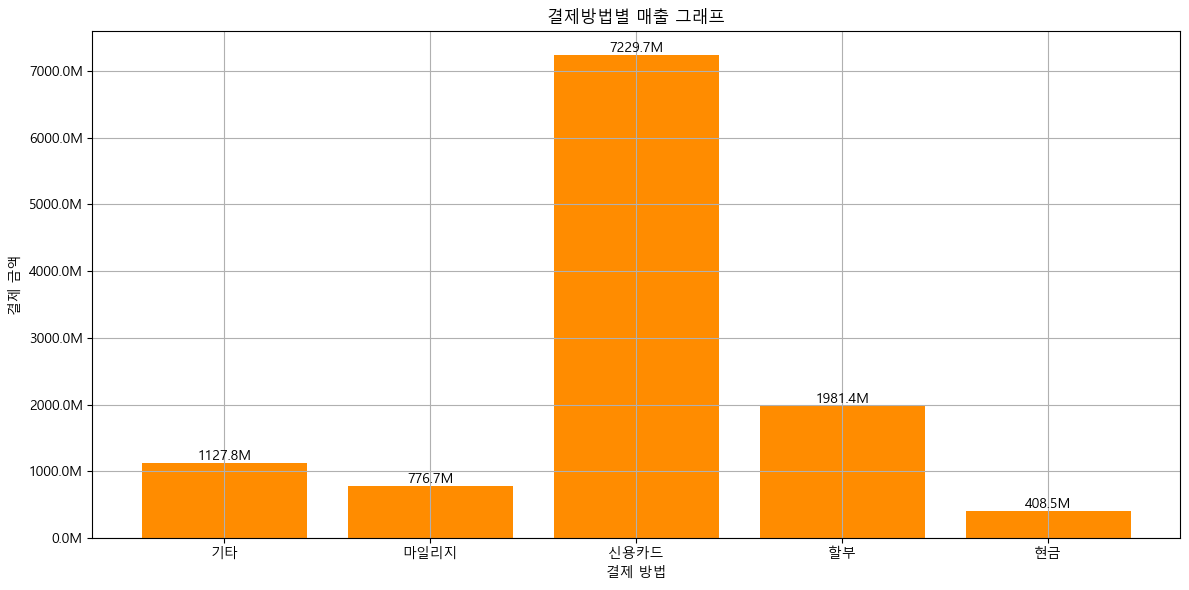

Index(['주문번호', '업체명', '상품명', '주문수량', '판매금액', '결제방법', '주문일자', '처리상태', '할부기간'], dtype='object')
현금 vs 신용카드 T-test: t-statistic = 4.31, p-value = 1.62e-05
현금 vs 할부 T-test: t-statistic = -41.42, p-value = 6.40e-271
현금 vs 마일리지 T-test: t-statistic = 13.63, p-value = 8.04e-42
현금 vs 기타 T-test: t-statistic = -62.86, p-value = 0.00e+00
할부 vs 마일리지 T-test: t-statistic = 43.27, p-value = 8.17e-287
할부 vs 신용카드 T-test: t-statistic = 42.19, p-value = 1.65e-276
마일리지 vs 신용카드 T-test: t-statistic = -47.44, p-value = 0.00e+00
마일리지 vs 기타 T-test: t-statistic = -67.43, p-value = 0.00e+00
기타 vs 신용카드 T-test: t-statistic = 65.33, p-value = 0.00e+00
기타 vs 할부 T-test: t-statistic = -7.42, p-value = 1.60e-13


In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind, shapiro, kruskal

# 결제 방법별 총 매출 계산
df_payment_sales = df6.groupby('결제방법')['판매금액'].sum().reset_index()
df_payment_sales['결제방법'] = df_payment_sales['결제방법'].astype(str).replace('nan', '기타')

# 결제 방법별 매출 그래프
plt.figure(figsize=(12, 6))
bars = plt.bar(df_payment_sales['결제방법'], df_payment_sales['판매금액'], color="darkorange")

def millions(x, pos):
    return '%1.1fM' % (x * 1e-6)
formatter = FuncFormatter(millions)
plt.gca().yaxis.set_major_formatter(formatter)

plt.ylabel('결제 금액', rotation=90)
plt.title('결제방법별 매출 그래프')
plt.xlabel('결제 방법')
plt.grid(True)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, '%1.1fM' % (yval * 1e-6), ha='center', va='bottom')

plt.tight_layout()
plt.show()



# 데이터프레임 컬럼명 확인
print(df6.columns)

# '결제 방법' 컬럼 확인 및 더미 변수 생성
if '결제방법' in df5.columns:
    df7 = pd.get_dummies(df5, columns=['결제방법'], drop_first=False)
else:
    print("Error: '결제방법' 컬럼이 데이터프레임에 없습니다.")

# 각 결제 방법별로 매출 금액 추출
payment_methods = ['현금', '신용카드', '할부', '마일리지', '기타']
sales_data = {}
for method in payment_methods:
    column_name = f'결제방법_{method}'
    if column_name in df7.columns and df7[df7[column_name] == 1]['판매금액'].notna().any():
        sales_data[method] = df7[df7[column_name] == 1]['판매금액']
    else:
        print(f'Warning: {method}에 대한 데이터가 부족하거나 존재하지 않습니다.')

# T-검정 수행 및 결과 출력
combinations = [
    ('현금', '신용카드'),
    ('현금', '할부'),
    ('현금', '마일리지'),
    ('현금', '기타'),
    ('할부', '마일리지'),
    ('할부', '신용카드'),
    ('마일리지', '신용카드'),
    ('마일리지', '기타'),
    ('기타', '신용카드'),
    ('기타', '할부')
]
for method1, method2 in combinations:
    if method1 in sales_data and method2 in sales_data:
        if len(sales_data[method1]) > 0 and len(sales_data[method2]) > 0:
            t_stat, p_val = ttest_ind(sales_data[method1], sales_data[method2], equal_var=False)
            print(f'{method1} vs {method2} T-test: t-statistic = {t_stat:.2f}, p-value = {p_val:.2e}')
        else:
            print(f'Error: {method1} 또는 {method2} 데이터가 부족합니다.')
    else:
        print(f'Error: {method1} 또는 {method2} 데이터가 존재하지 않습니다.')



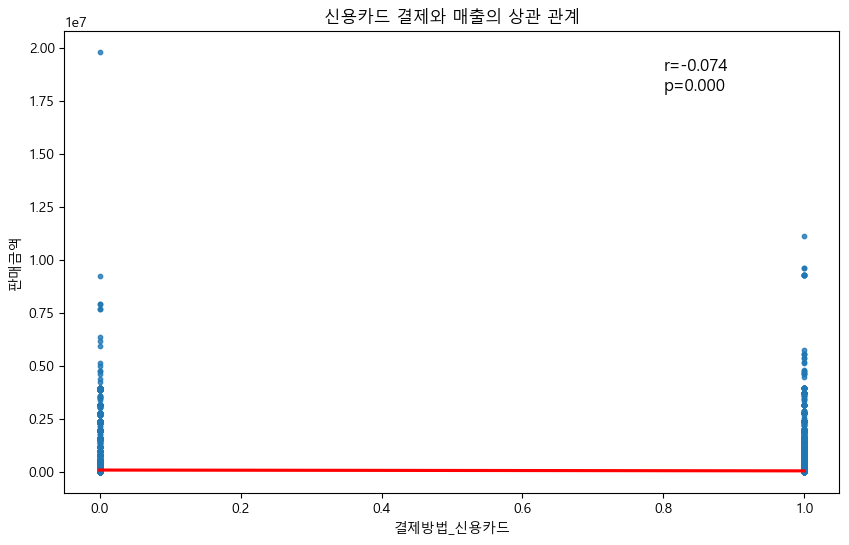

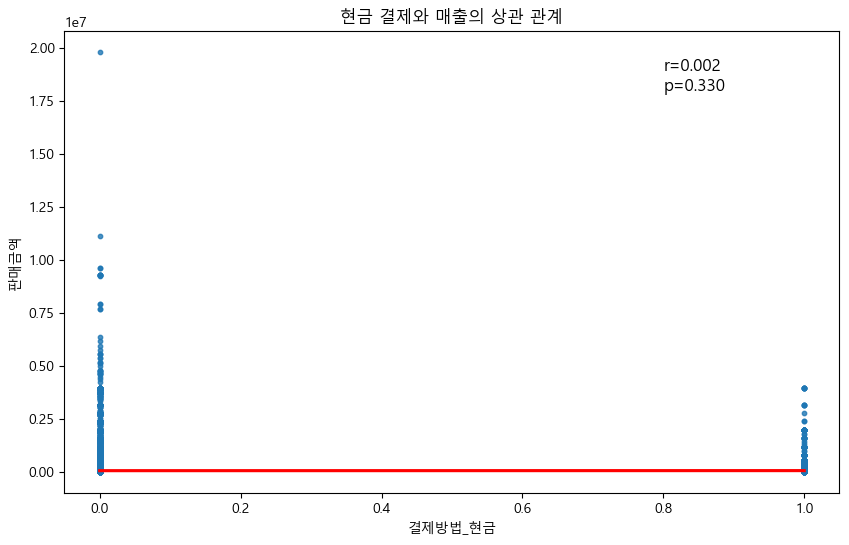

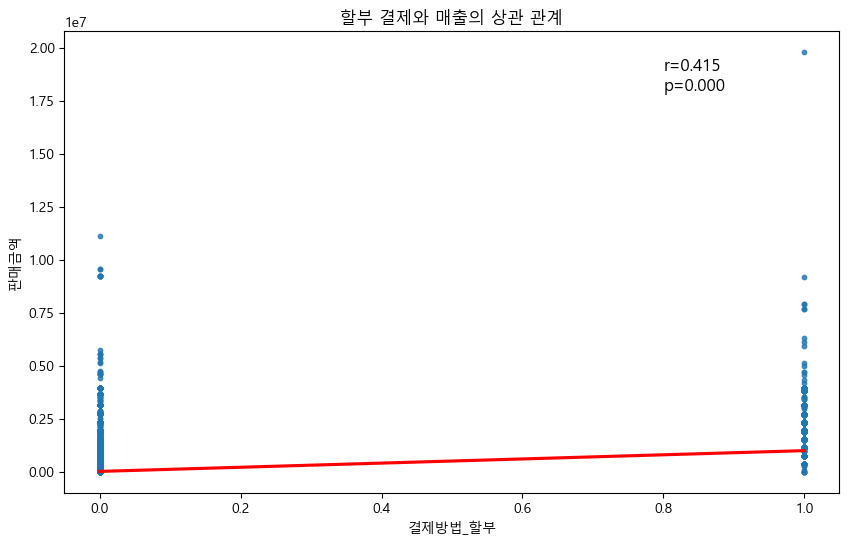

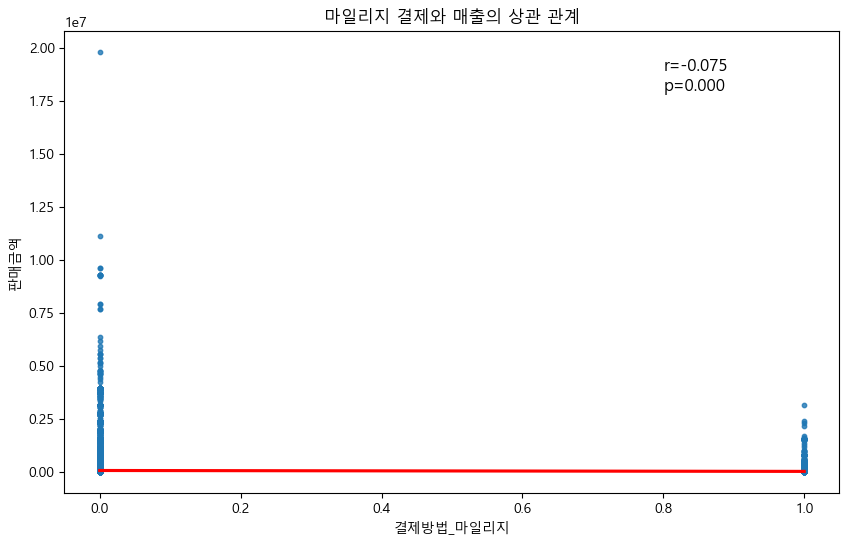

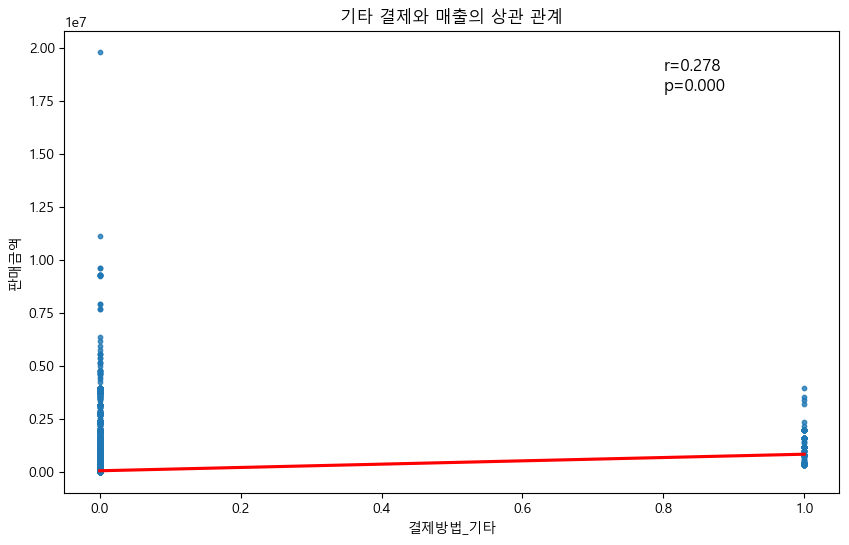

In [26]:

#회귀선 플롯 그래프
# 결제 방법을 숫자로 변환 (더미 변수 사용)
df7 = pd.get_dummies(df5, columns=['결제방법'], drop_first=False)

# 회귀선 플롯을 그리는 함수
def plot_regression(data, x_col, y_col, title):
    r, p = stats.pearsonr(data[x_col], data[y_col])
    plt.figure(figsize=(10, 6))
    sns.regplot(x=x_col, y=y_col, data=data, scatter_kws={'s':10}, line_kws={'color':'red'})
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.text(data[x_col].min() + 0.8, 18000000, 'r=%0.3f\np=%0.3f' % (r, p), fontsize=12)  # y 위치를 0.2에서 0.5로 변경
    plt.show()

# 신용카드
plot_regression(df7, '결제방법_신용카드', '판매금액', '신용카드 결제와 매출의 상관 관계')

# 현금
plot_regression(df7, '결제방법_현금', '판매금액', '현금 결제와 매출의 상관 관계')

# 할부
plot_regression(df7, '결제방법_할부', '판매금액', '할부 결제와 매출의 상관 관계')

# 마일리지
plot_regression(df7, '결제방법_마일리지', '판매금액', '마일리지 결제와 매출의 상관 관계')

# 기타
plot_regression(df7, '결제방법_기타', '판매금액', '기타 결제와 매출의 상관 관계')

In [27]:
# 데이터 불러오기 (코로나 확진자 데이터와 매출 데이터)
covid_data_path = './코로나 확진자.xlsx'
covid = pd.read_excel(covid_data_path)
sales = df6
# '일자' 열의 첫 번째 값이 '누적(명)'인 경우, 첫 번째 행을 제거합니다.
if covid['일자'].iloc[0] == '누적(명)':
    covid = covid.iloc[1:]
# 데이터 전처리
covid['일자'] = pd.to_datetime(covid['일자'], errors='coerce')  # 'coerce' 옵션을 사용하여 오류를 NaT로 처리
covid = covid.dropna(subset=['일자'])  # NaT가 포함된 행 제거
covid['국내발생(명)'] = pd.to_numeric(covid['국내발생(명)'], errors='coerce')  # '국내발생(명)'을 숫자 형식으로 변환
covid = covid.dropna(subset=['국내발생(명)'])  # 변환할 수 없는 값이 포함된 행 제거
covid['연월'] = covid['일자'].dt.to_period('M')
monthly_cases = covid.groupby('연월')['국내발생(명)'].sum().reset_index()
sales['주문일자'] = pd.to_datetime(sales['주문일자'], errors='coerce')
sales = sales.dropna(subset=['주문일자'])
sales['판매금액'] = pd.to_numeric(sales['판매금액'], errors='coerce')  # '판매금액'을 숫자 형식으로 변환
sales = sales.dropna(subset=['판매금액'])  # 변환할 수 없는 값이 포함된 행 제거
sales['연월'] = sales['주문일자'].dt.to_period('M')
monthly_sales = sales.groupby('연월')['판매금액'].sum().reset_index()
# 상관관계 분석을 위한 데이터 병합
merged_data = pd.merge(monthly_cases, monthly_sales, on='연월')

# 2021년 8월부터 2022년 12월까지의 데이터만 필터링
monthly_cases = monthly_cases[(monthly_cases['연월'] >= '2021-08') & (monthly_cases['연월'] <= '2022-12')]
monthly_sales = monthly_sales[(monthly_sales['연월'] >= '2021-08') & (monthly_sales['연월'] <= '2022-12')]
# 그래프 시각화
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('연도-월')
ax1.set_ylabel('확진자 수', color='tab:blue')
ax1.plot(monthly_cases['연월'].astype(str), monthly_cases['국내발생(명)'], color='tab:blue', label='코로나 확진자 수')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2 = ax1.twinx()
ax2.set_ylabel('매출 금액', color='tab:red')
ax2.plot(monthly_sales['연월'].astype(str), monthly_sales['판매금액'], color='tab:red', label='매출 금액')
ax2.tick_params(axis='y', labelcolor='tab:red')
# x축 라벨 간격 조정
plt.xticks(rotation=45, ha='right')
# 그리드 및 레전드 추가
fig.tight_layout()
plt.title('코로나 확진자 수와 매출 금액 비교')
ax1.grid(True)
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

# 로그 변환
merged_data['log_국내발생(명)'] = np.log1p(merged_data['국내발생(명)'])
merged_data['log_판매금액'] = np.log1p(merged_data['판매금액'])
# 상관계수 계산
correlation, p_value = pearsonr(merged_data['log_국내발생(명)'], merged_data['log_판매금액'])
# 산점도 및 추세선 시각화
plt.figure(figsize=(10, 6))
sns.regplot(x='log_국내발생(명)', y='log_판매금액', data=merged_data, scatter_kws={'s':50}, line_kws={'color':'red'})
plt.title(f'로그 변환된 코로나 확진자 수와 매출 금액 간의 상관관계 (상관계수: {correlation:.2f}, p-value: {p_value:.2e})')
plt.xlabel('로그 변환된 국내발생(명)')
plt.ylabel('로그 변환된 판매금액')
plt.grid(True)
# 데이터 포인트에 주석 추가 (예: 최대값 강조)
max_point = merged_data.loc[merged_data['log_국내발생(명)'].idxmax()]
plt.annotate('최대 국내발생',
             xy=(max_point['log_국내발생(명)'], max_point['log_판매금액']),
             xytext=(max_point['log_국내발생(명)'] + 0.5, max_point['log_판매금액'] + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: './코로나 확진자.xlsx'

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# 데이터 로드 및 전처리


# '일자' 열의 첫 번째 값이 '누적(명)'인 경우, 첫 번째 행 제거
if covid['일자'].iloc[0] == '누적(명)':
    covid = covid.iloc[1:]

# 데이터 전처리
covid['일자'] = pd.to_datetime(covid['일자'], errors='coerce')
covid = covid.dropna(subset=['일자'])
covid['국내발생(명)'] = pd.to_numeric(covid['국내발생(명)'], errors='coerce')
covid = covid.dropna(subset=['국내발생(명)'])
covid['연월'] = covid['일자'].dt.to_period('M')
monthly_cases = covid.groupby('연월')['국내발생(명)'].sum().reset_index()

sales['주문일자'] = pd.to_datetime(sales['주문일자'], errors='coerce')
sales = sales.dropna(subset=['주문일자'])
sales['판매금액'] = pd.to_numeric(sales['판매금액'], errors='coerce')
sales = sales.dropna(subset=['판매금액'])
sales['연월'] = sales['주문일자'].dt.to_period('M')
monthly_sales = sales.groupby('연월')['판매금액'].sum().reset_index()

# 상관관계 분석을 위한 데이터 병합
merged_data = pd.merge(monthly_cases, monthly_sales, on='연월')

# 기준 설정 (예: 월간 평균 3000명)
threshold = 3000

# 기준에 따라 데이터 분할
high_cases = merged_data[merged_data['국내발생(명)'] > threshold]['판매금액']
low_cases = merged_data[merged_data['국내발생(명)'] <= threshold]['판매금액']

# t-test 수행
t_stat, p_value = ttest_ind(high_cases, low_cases, equal_var=False)

print(f"t-통계량: {t_stat:.2f}, p-값: {p_value:.2e}")




t-통계량: 3.30, p-값: 6.80e-03
